In [1]:
# Setups
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os, fnmatch
import datetime

plt.rcParams["font.family"] = "arial"
plt.rcParams.update({'font.size': 14})

def cm_to_inch(value):
    return value/2.54

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import LorentzianModel, QuadraticModel, LinearModel, VoigtModel

def add_peak1(prefix, center, amplitude=0.002, sigma=0.0075):
    peak = VoigtModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center, max=center*(1+PeakVariance), min=center*(1-PeakVariance))
    pars[prefix + 'amplitude'].set(amplitude, min=0)
    pars[prefix + 'sigma'].set(sigma, max=setsigma, min=0)
    return peak, pars
# Setups
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os, fnmatch
import datetime

plt.rcParams["font.family"] = "arial"
plt.rcParams.update({'font.size': 14})

def cm_to_inch(value):
    return value/2.54

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [2]:



## whereistemp_section 숫자 알아보기
TestFileName = "HS-0_2m_11keV_WAXS_PPMA_030c_att0_5sec_0334.dat_bsub"




########################### 아래는 코딩 부분 ###################
print("Section splited by [_]:\n")
print(TestFileName.split('_'))


Section splited by [_]:

['HS-0', '2m', '11keV', 'WAXS', 'PPMA', '030c', 'att0', '5sec', '0334.dat', 'bsub']


0261
['D:/PSPMMA_DIS/etc/HS-TRWAXS_0_2M_19KeV_PMMA_att0_030C_3sec_0261.dat_bsub']


ValueError: could not convert string to float: '5.0482170e+00  -2.6300000e-04'

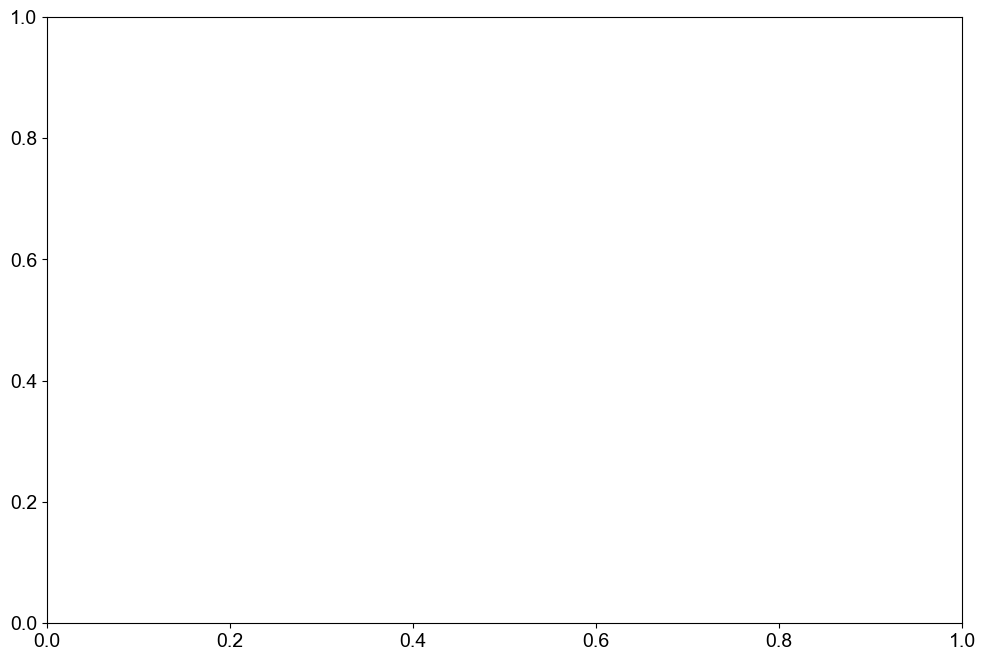

In [4]:
Beamline ='9A'


# File Directory + File selection
# 끈 따옴표안에 주소를 넣을 것
FileDir = r"D:\PSPMMA_DIS\etc"
FileDir = FileDir.replace(os.sep,"/")
FileDir = FileDir + "/"
whereistemp_section = 6
# 온도가 표기된 위치 "_" 구분했을때 위치 명치할 것
# 예시 'name_date_sample_040C_5s.dat'
# ['name', 'date', 'sample', '040C', '5s.dat']  => 4 번째니까 4 입력


FileNumStart, FileNumEnd, IntervalFile = (261, 262, 1) 
#파일이름 뒤 인덱싱 넘버로 하면 되고 back만 반응함. 3번쨰는 fileinterval 얼마나 띄엄하는지


qmin, qmax = 0.5, 2.4   #픽을 피팅할 구간 정하기     

PeakVariance = 0.1 
#처음 피팅된 값에서 피팅허용할 범위 ex) 0.1 이면 초기 피팅된 값 10% 이내로만 움직일 수 있음.
setsigma = 0.1
# 픽의 최소 넓이 정하는 것

## Allowance 픽 발견 민감도 낮으면 많은 픽들을 발견함
PeakHeightAllow = 10 # The higher number allows the sharper peaks
PeakBroadnessAllow = 10  # The higher number allows the narrower peaks




#################################################################################

fitqmin, fitqmax = qmin, qmax
fitqmin2,fitqmax2 = fitqmin, fitqmax
NumofData = int((FileNumEnd - FileNumStart + 1)/IntervalFile)
dataCollection = [[]]
fig = plt.figure(figsize=(cm_to_inch(30),cm_to_inch(20)))
ax = fig.add_subplot(111)
peakdata = []

n = 1
                


for FileIndex in range(FileNumStart,FileNumEnd+1,IntervalFile):

    if Beamline =='9A':
        FileIndex2 = ("%04d" %(FileIndex))
    else:
        FileIndex2 = ("%05d" %(FileIndex))
    
    print(FileIndex2)
    SelectData = "*_"+FileIndex2+"*"
    OtherwayData = find(SelectData, FileDir)
    print(OtherwayData)
    data = np.loadtxt("%s" %(OtherwayData[0]), dtype=np.str_, comments = '%',delimiter=",")
    data_size = np.shape(data)[0]
    data_temp = np.zeros((data_size,2))
    for i in range(data_size):
        data_temp[i,0] = data[i].split('   ')[1]
        data_temp[i,1] = data[i].split('   ')[2]
    data = data_temp
    if n == 1:
        dataCollection = data[:,0]
        dataCollection = np.reshape(dataCollection,(dataCollection.size,1))
    AddData = np.reshape(data[:,1],(data[:,1].size, 1))   
    dataCollection = np.hstack((dataCollection,AddData))
    x = data[:,0]
    y = dataCollection[:,n]
    
    plt.plot(x, y, 'k')

    
    fitrange = [i for i, value in enumerate(x) if (value > qmin) * (value < qmax)]
    y3 = y[fitrange]
    y3 = y3[~np.isnan(y3)]
    fitrange2 = [i for i, value in enumerate(y3) if (value > 0)]
    y3 = y3[fitrange2]
    PeakHeightAllowFactor = (np.max(y3) - np.mean(np.power(y3, 0.5)) ** 2) / 500 * PeakHeightAllow
    #print(PeakHeightAllowFactor)
    PeakBroadnessAllowFactor = (qmax - qmin) / 50 * PeakBroadnessAllow
    #print(PeakBroadnessAllowFactor)
    ## Data fitting
    fitrange = [i for i, value in enumerate(x) if (value > fitqmin) * (value < fitqmax)]
    x2 = x[fitrange]
    y2 = y[fitrange]

    peaks, properties = find_peaks(y2, prominence = PeakHeightAllowFactor, width = PeakBroadnessAllowFactor)
    prominences = peak_prominences(y2, peaks)[0]
    plt.plot(x2[peaks], y2[peaks], "rx",markersize = 10, markeredgewidth = 3)
    roughfitq = x2[peaks]
    

    #MaxNumPeaksUse = len(x2[peaks])
    MaxNumPeaksUse = 2
    
    xdat = dataCollection[:,0]
    #xx = dataCollection[:,0]
    ydat = dataCollection[:,n]

    fitrange = [i for i, value in enumerate(xdat) if (value > fitqmin2) * (value < fitqmax2)]
    xdat = xdat[fitrange]
    ydat = ydat[fitrange]

    model = LinearModel(prefix='bkg_')
    params = model.make_params(a=0, b=0)
    
    rough_peak_positions = roughfitq[0:MaxNumPeaksUse]
    
    for i, cen in enumerate(rough_peak_positions):
        peak, pars = add_peak1('lz%d_' % (i+1), cen)
        model = model + peak
        params.update(pars)

    init = model.eval(params, x=xdat)
    result = model.fit(ydat, params, x=xdat)

    comps = result.eval_components()

    peakdata02 = []
    peakdata01 = []
    
    k3 = OtherwayData[0].split('_')
    k4 = k3[whereistemp_section-1]
    peakdata01 = k4[:-1]
    
    
    for name, par in result.params.items():
        if 'center' in name:
            peakdata02 = np.array([name, par.value])
            peakdata01 = np.hstack((peakdata01,peakdata02))
    for name, par in result.params.items():
        if 'height' in name:
            peakdata02 = np.array([name, par.value])
            peakdata01 = np.hstack((peakdata01,peakdata02))
            
    for name, par in result.params.items():
        if 'fwhm' in name:
            peakdata02 = np.array([name, par.value])
            peakdata01 = np.hstack((peakdata01,peakdata02))
    
    for name, par in result.params.items():
        if 'amplitude' in name:
            peakdata02 = np.array([name, par.value])
            peakdata01 = np.hstack((peakdata01,peakdata02))
            

    
    if n == 1:
        peakdata = peakdata01
    else:
        peakdata = np.vstack((peakdata,peakdata01))
        
        
    n = n + 1    
    
plt.xlabel("$\it{q}$ (A$^\mathrm{-1}$)", fontsize = 16)
plt.ylabel("$\it{I}$ (a.u)", fontsize = 17)

In [24]:
name = 'PMMA1-homopolymer'

e = datetime.datetime.now()
ExportFileName = ("%s%02d%02d_%s_data_%02d%02d%02d.csv" % (e.year, e.month, e.day, name, e.hour, e.minute, e.second))
pd.DataFrame(peakdata).to_csv(ExportFileName)

In [13]:
k3 = data[0].split('   ')[1]
print(k3)

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [11]:
print(np.shape(data)[0])
k5 = np.zeros((1645,3))
print(k5)

1645
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
'''
    if FileIndex < 10:
        FileIndex2 = "0000"+str(FileIndex)
    elif FileIndex <100:
        FileIndex2 = "000"+str(FileIndex)
    elif FileIndex <1000:
        FileIndex2 = "00"+str(FileIndex)
    elif FileIndex <10000:
        FileIndex2 = "0"+str(FileIndex)
    elif FileIndex <100000:
        FileIndex2 = str(FileIndex)
    #print(FileIndex2)
'''

In [27]:
name = 'test'

e = datetime.datetime.now()
ExportFileName = ("%s%02d%02d_%s_data_%02d%02d%02d.csv" % (e.year, e.month, e.day, name, e.hour, e.minute, e.second))
pd.DataFrame(data).to_csv(ExportFileName)
